Goal:

Increase the acc

to test:

anothers ranking functions and anothers clustering methods

keeping the interpretability ? à voir

functions to try:

ranking:
weighted sum 
electre

clustering:
EM... ?

In [1]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from gurobipy import Model, GRB

In [3]:
from data import Dataloader
from models import RandomExampleModel, TwoClustersMIP
import metrics

In [4]:
# Loading the data
X = np.load("../data/dataset_4/X_x.npy")
Y = np.load("../data/dataset_4/Y_y.npy")

### Melanie work

In [5]:
n_pieces = 5
n_clusters = 2
model_1 = TwoClustersMIP(n_pieces, n_clusters)
model_1.fit(X[:400,:], Y[:400,:])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-19


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2044 rows, 1648 columns and 24816 nonzeros
Model fingerprint: 0xc9858721
Variable types: 848 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]
Presolve removed 10 rows and 8 columns
Presolve time: 0.03s
Presolved: 2034 rows, 1640 columns, 22380 nonzeros
Variable types: 840 continuous, 800 integer (800 binary)

Root relaxation: objective 0.000000e+00, 982 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  220 

<gurobi.Model MIP instance TwoClustersMIP: 2044 constrs, 1648 vars, Parameter changes: Username=(user-defined)>

In [ ]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

In [ ]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.02918935  0.26452602]
 [-0.23504386 -0.06949957]
 [-0.00167842 -0.08688312]
 [-0.05042343 -0.25713769]
 [-0.04372049  0.0350513 ]]


In [ ]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]]


In [ ]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.8


In [ ]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.5845
Percentage of explained preferences for all samples: 0.5845


In [ ]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 0]


In [ ]:
# Ground truth are also provided:
Z = np.load("../data/dataset_4/Z_z.npy")

# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [ ]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.6577508754377188
Cluster intersection for all samples: 0.6577508754377188


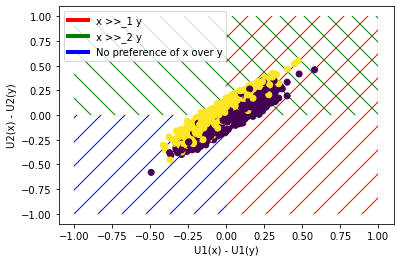

In [ ]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [ ]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP

parameters = {"n_pieces": 5, "n_clusters": 2} # Can be completed
model = TwoClustersMIP(**parameters)
model.fit(X, Y)

# Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

In [ ]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find another model that will work well with larger data instances.

[0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545 0.50505051 0.55555556
 0.60606061 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586
 0.90909091 0.95959596 1.01010101 1.06060606 1.11111111 1.16161616
 1.21212121 1.26262626 1.31313131 1.36363636 1.41414141 1.46464646
 1.51515152 1.56565657 1.61616162 1.66666667 1.71717172 1.76767677
 1.81818182 1.86868687 1.91919192 1.96969697 2.02020202 2.07070707
 2.12121212 2.17171717 2.22222222 2.27272727 2.32323232 2.37373737
 2.42424242 2.47474747 2.52525253 2.57575758 2.62626263 2.67676768
 2.72727273 2.77777778 2.82828283 2.87878788 2.92929293 2.97979798
 2.96969697 2.91919192 2.86868687 2.81818182 2.76767677 2.71717172
 2.66666667 2.61616162 2.56565657 2.51515152 2.46464646 2.41414141
 2.36363636 2.31313131 2.26262626 2.21212121 2.16161616 2.11111111
 2.06060606 2.01010101 1.91919192 1.81818182 1.71717172 1.61616162
 1.51515152 1.41414141 1.31313131 1.21212121 1.11111111 1.0101

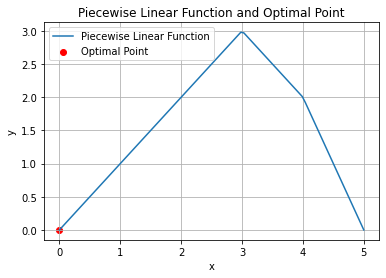

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the piecewise linear function
breakpoints = [0, 1, 2, 3, 4, 5]
values = [0, 1, 2, 3, 2, 0]

# Create a range of x values for the plot
x_values = np.linspace(0, 5, 100)
y_values = np.interp(x_values, breakpoints, values)

# Create a Gurobi optimization model (just for reference)
model = Model()
x = model.addVar(lb=0, ub=5, name="x")
y = model.addVar(lb=0, ub=5, name="y")
model.setObjective(y, GRB.MINIMIZE)
model.optimize()

# Get the optimal value of x from the model
optimal_x = x.X

# Plot the piecewise linear function
plt.plot(x_values, y_values, label="Piecewise Linear Function")
plt.scatter([optimal_x], [np.interp(optimal_x, breakpoints, values)], color='red', label="Optimal Point")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.title("Piecewise Linear Function and Optimal Point")
plt.show()


In [ ]:
from gurobipy import *

# Given points
given_points = [(1, 2), (2, 4), (3, 1), (4, 3), (5, 5)]

# Create a Gurobi optimization model
model = Model()

# Number of breakpoints (3 pieces means 4 breakpoints)
num_breakpoints = 4

# Create variables for breakpoints and values
breakpoints = []
values = []

for i in range(num_breakpoints):
    breakpoints.append(model.addVar(lb=1, ub=5, name=f"breakpoint_{i}"))

for i in range(num_breakpoints - 1):
    values.append(model.addVar(lb=0, ub=5, name=f"value_{i}"))

# Define the objective function (minimize sum of squared errors)
error_terms = []

for x, y in given_points:
    in_segment = None
    for i in range(num_breakpoints - 1):
        if x >= breakpoints[i].LB and x < breakpoints[i + 1].UB:
            in_segment = i
            break
    if in_segment is not None:
        predicted_y = values[in_segment].X + (x - breakpoints[in_segment].X) * (
                    values[in_segment + 1].X - values[in_segment].X) / (
                                  breakpoints[in_segment + 1].X - breakpoints[in_segment].X)
        error_terms.append((y - predicted_y) ** 2)

model.setObjective(quicksum(error_terms), GRB.MINIMIZE)

# Add constraints to ensure breakpoints are in ascending order
for i in range(num_breakpoints - 1):
    model.addConstr(breakpoints[i] <= breakpoints[i + 1], f"order_constraint_{i}")

# Optimize the model
model.optimize()

# Print the optimal solution
if model.status == GRB.OPTIMAL:
    print("Optimal Solution:")
    for i in range(num_breakpoints):
        print(f"breakpoint_{i} = {breakpoints[i].X}")
    for i in range(num_breakpoints - 1):
        print(f"value_{i} = {values[i].X}")
else:
    print("No solution found.")


AttributeError: Index out of range for attribute 'LB'

In [ ]:
from gurobipy import Model, GRB, quicksum
import numpy as np

# Define the piecewise linear function
breakpoints = [1, 2, 3]  # breakpoints

# Dataset
x_data = np.array([0.5, 1.5, 2.5, 3.5, 4.5])  # x-values
y_data = np.array([1, 2, 3, 4, 5])  # y-values

# Create a Gurobi optimization model
model = Model()

# Add variables for the y-values at the breakpoints
y = model.addVars(breakpoints, lb=-GRB.INFINITY, name="y")

# Define the piecewise linear function
def piecewise_linear(x):
    if x < breakpoints[0]:
        return y[breakpoints[0]]
    elif x < breakpoints[1]:
        return y[breakpoints[0]] + (x - breakpoints[0]) * (y[breakpoints[1]] - y[breakpoints[0]]) / (breakpoints[1] - breakpoints[0])
    elif x < breakpoints[2]:
        return y[breakpoints[1]] + (x - breakpoints[1]) * (y[breakpoints[2]] - y[breakpoints[1]]) / (breakpoints[2] - breakpoints[1])
    else:
        return y[breakpoints[2]]

# Set the objective to minimize the sum of squared errors
model.setObjective(quicksum((y_data[i] - piecewise_linear(x_data[i]))**2 for i in range(len(x_data))), GRB.MINIMIZE)

# Optimize the model
model.optimize()

# Get the optimal y-values at the breakpoints
optimal_values = [y[i].X for i in breakpoints]

print("Optimal y-values at breakpoints:", optimal_values)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 3 columns and 0 nonzeros
Model fingerprint: 0x12ca88f7
Model has 5 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+00, 2e+01]


  QObjective range [1e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.03s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 5 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.50000000e+01  5.50000000e+01  0.00e+00 5.25e+00  0.00e+00     0s
   1   7.36842108e-01  7.36956859e-01  4.34e-10 7.21e-06  0.00e+00     0s
   2   7.36842105e-01  7.36842105e-01  7.95e-14 7.23e-12  0.00e+00     0s

Barrier solved model in 2 iterations and 0.05 seconds (0.00 work units)
Optimal objective 7.36842105e-01

Optimal y-values at breakpoints: [1.157894736841037, 2.210526315784866, 4.421052631574788]


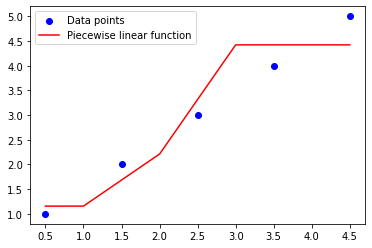

In [ ]:
import matplotlib.pyplot as plt

# Plot the dataset
plt.scatter(x_data, y_data, color='blue', label='Data points')

# Generate x-values for the piecewise function
x_values = np.linspace(min(x_data), max(x_data), 1000)

# Define a function to get the y-value for a given x-value
def get_y_value(x):
    if x <= breakpoints[0]:
        return y[breakpoints[0]].X
    elif x <= breakpoints[1]:
        return y[breakpoints[0]].X + (x - breakpoints[0]) * (y[breakpoints[1]].X - y[breakpoints[0]].X) / (breakpoints[1] - breakpoints[0])
    elif x <= breakpoints[2]:
        return y[breakpoints[1]].X + (x - breakpoints[1]) * (y[breakpoints[2]].X - y[breakpoints[1]].X) / (breakpoints[2] - breakpoints[1])
    else:
        return y[breakpoints[2]].X

# Generate y-values for the piecewise function
y_values = [get_y_value(x) for x in x_values]

# Plot the piecewise function
plt.plot(x_values, y_values, color='red', label='Piecewise linear function')

plt.legend()
plt.show()

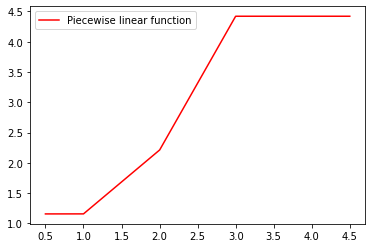

In [ ]:
# Define the conditions
conditions = [x_values <= breakpoints[0], 
              (x_values > breakpoints[0]) & (x_values <= breakpoints[1]), 
              (x_values > breakpoints[1]) & (x_values <= breakpoints[2]), 
              x_values > breakpoints[2]]

# Define the functions
functions = [lambda x: y[breakpoints[0]].X, 
             lambda x: y[breakpoints[0]].X + (x - breakpoints[0]) * (y[breakpoints[1]].X - y[breakpoints[0]].X) / (breakpoints[1] - breakpoints[0]), 
             lambda x: y[breakpoints[1]].X + (x - breakpoints[1]) * (y[breakpoints[2]].X - y[breakpoints[1]].X) / (breakpoints[2] - breakpoints[1]), 
             lambda x: y[breakpoints[2]].X]

# Generate y-values for the piecewise function
y_values = np.piecewise(x_values, conditions, functions)

# Plot the piecewise function
plt.plot(x_values, y_values, color='red', label='Piecewise linear function')

plt.legend()
plt.show()

In [ ]:
import gurobipy as gp
from gurobipy import GRB

def find_breakpoints(points, num_breakpoints=3):
    # Create a Gurobi model
    model = gp.Model("PiecewiseLinearFit")

    # Define the decision variables (breakpoints)
    breakpoints = []
    for i in range(num_breakpoints):
        breakpoints.append(model.addVar(vtype=GRB.CONTINUOUS, name=f"breakpoint_{i}"))

    # Set up the objective function to minimize the sum of squared errors
    objective = 0
    for x, y in points:
        piecewise_expr = 0
        for i in range(num_breakpoints):
            piecewise_expr += breakpoints[i] * (x >= breakpoints[i])
        objective += (y - piecewise_expr) ** 2
    model.setObjective(objective, GRB.MINIMIZE)

    # Add constraints to ensure breakpoints are in ascending order
    for i in range(num_breakpoints - 1):
        model.addConstr(breakpoints[i] <= breakpoints[i + 1])

    # Optimize the model
    model.optimize()

    # Extract the values of the breakpoints
    breakpoint_values = [breakpoints[i].X for i in range(num_breakpoints)]

    return breakpoint_values

# Example usage
points = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
breakpoints = find_breakpoints(points)
print("Optimal Breakpoints:", breakpoints)


TypeError: unsupported operand type(s) for *: 'Var' and 'TempConstr'

In [ ]:
def find_breakpoints(points, num_breakpoints=3):
    # Create a Gurobi model
    model = gp.Model("PiecewiseLinearFit")

    # Define the decision variables (breakpoints)
    breakpoints = []
    for i in range(num_breakpoints):
        breakpoints.append(model.addVar(vtype=GRB.CONTINUOUS, name=f"breakpoint_{i}"))

    # Define the binary variables
    binary_vars = []
    for i in range(num_breakpoints):
        binary_vars.append(model.addVars(len(points), vtype=GRB.BINARY, name=f"binary_{i}"))

    # Set up the objective function to minimize the sum of squared errors
    objective = 0
    for j, (x, y) in enumerate(points):
        piecewise_expr = 0
        for i in range(num_breakpoints):
            piecewise_expr += breakpoints[i] * binary_vars[i][j]
            model.addConstr(binary_vars[i][j] >= (x - breakpoints[i]) / (max(points)[0] - min(points)[0]))
        objective += (y - piecewise_expr) ** 2
    model.setObjective(objective, GRB.MINIMIZE)

    # Add constraints to ensure breakpoints are in ascending order
    for i in range(num_breakpoints - 1):
        model.addConstr(breakpoints[i] <= breakpoints[i + 1])

    # Optimize the model
    model.optimize()

    # Extract the values of the breakpoints
    breakpoint_values = [breakpoints[i].X for i in range(num_breakpoints)]

    return breakpoint_values

# Example usage
points = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
breakpoints = find_breakpoints(points)
print("Optimal Breakpoints:", breakpoints)

TypeError: unsupported operand type(s) for ** or pow(): 'gurobipy.QuadExpr' and 'int'

### Pai work


In [7]:
# Import libraries
import numpy as np
import pickle
import optuna
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression  # For ordinal regression
from sklearn.metrics import precision_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

In [12]:
seed = 42  # Set random seed for reproducibility

In [9]:
# Loading the data
X = np.load("../data/dataset_10/X_x.npy")
Y = np.load("../data/dataset_10/Y_y.npy")
Z = np.load("../data/dataset_10/Z_z.npy")

In [10]:
print(X.shape, Y.shape, Z.shape)

(40002, 10) (40002, 10) (40002,)


### Approach 1 

#### Data dealing

In [28]:
# Initialize an empty DataFrame
D_list = []
labels = []
cluster_ids = []

# Populate the DataFrame
for i in range(len(X)):
    # Choose randomly between x-y and y-x
    if np.random.rand() > 0.5:
        D = X[i] - Y[i]
        D_list.append(D)
        labels.append(1)
        cluster_ids.append(Z[i])
    else:
        D = Y[i] - X[i]
        D_list.append(D)
        labels.append(0)
        cluster_ids.append(Z[i])

df = pd.DataFrame({'D': D_list, 'label': labels, 'cluster_id': cluster_ids})

Df_train, Df_val = train_test_split(df, test_size=0.2, random_state=seed)


#### Training LogisticRegression

In [15]:
# Initialize a dictionary to store the best models
best_models = {}

def optimize_cluster(cluster_id, df_cluster, val_cluster):
    def objective(trial):
        # Hyperparameters to be tuned
        
        r = trial.suggest_float('l1_ratio', 0, 1, log=False)
        c = trial.suggest_float('C', 1e-10, 1000, log=True)

        # Separate the features (D) and target (label)
        X_train = np.array(df_cluster['D'].tolist())
        y_train = df_cluster['label'].values
        
        X_val = np.array(val_cluster['D'].tolist())
        y_val = val_cluster['label'].values 
      
        # Create and fit the logistic regression model with hyperparameters
        model = LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=r, C=c)
        model.fit(X_train, y_train)
        
        # Predict on the validation set and calculate accuracy
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        return accuracy

    # Create an Optuna study object and optimize the objective function
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)  # Adjust the number of trials as necessary
    
    # Store the best model for the cluster
    best_params = study.best_trial.params
    best_model = LogisticRegression(**best_params, random_state=seed, max_iter=1000)

    X = np.array(df_cluster['D'].tolist())
    y = df_cluster['label'].values
    
    best_model.fit(X, y)  # Refit using all data in the cluster
    best_models[cluster_id] = best_model

    print(f"Best trial for cluster {cluster_id}: {best_params}")

In [16]:
# Iterate over each unique cluster_id and optimize
for cluster_id in Df_train['cluster_id'].unique():
    df_cluster = Df_train[Df_train['cluster_id'] == cluster_id]
    val_cluster = Df_test[Df_test['cluster_id'] == cluster_id]
    
    optimize_cluster(cluster_id, df_cluster, val_cluster)

[I 2024-02-07 16:35:24,619] A new study created in memory with name: no-name-0efa094e-653c-4b64-a76b-d3d43e9a2f20
[I 2024-02-07 16:35:24,628] Trial 0 finished with value: 0.49695550351288054 and parameters: {'l1_ratio': 0.8004346874443589, 'C': 5.424833612270694e-06}. Best is trial 0 with value: 0.49695550351288054.
[I 2024-02-07 16:35:24,652] Trial 1 finished with value: 0.9489461358313818 and parameters: {'l1_ratio': 0.23144469792273104, 'C': 0.2759981072776366}. Best is trial 1 with value: 0.9489461358313818.
[I 2024-02-07 16:35:24,661] Trial 2 finished with value: 0.49695550351288054 and parameters: {'l1_ratio': 0.6281437990247527, 'C': 1.1934449379664418e-07}. Best is trial 1 with value: 0.9489461358313818.
[I 2024-02-07 16:35:24,686] Trial 3 finished with value: 0.9494145199063232 and parameters: {'l1_ratio': 0.4202900510669866, 'C': 41.783887670270026}. Best is trial 3 with value: 0.9494145199063232.
[I 2024-02-07 16:35:24,695] Trial 4 finished with value: 0.49695550351288054 an

Best trial for cluster 1: {'l1_ratio': 0.4202900510669866, 'C': 41.783887670270026}


[I 2024-02-07 16:35:39,808] Trial 7 finished with value: 0.9915730337078652 and parameters: {'l1_ratio': 0.012306874234627174, 'C': 0.024544054946397522}. Best is trial 7 with value: 0.9915730337078652.
[I 2024-02-07 16:35:39,862] Trial 8 finished with value: 0.9901685393258427 and parameters: {'l1_ratio': 0.3124199195530938, 'C': 228.80001215370712}. Best is trial 7 with value: 0.9915730337078652.
[I 2024-02-07 16:35:39,884] Trial 9 finished with value: 0.9859550561797753 and parameters: {'l1_ratio': 0.19618365528699866, 'C': 0.0021175227551395387}. Best is trial 7 with value: 0.9915730337078652.
[I 2024-02-07 16:35:39,910] Trial 10 finished with value: 0.9906367041198502 and parameters: {'l1_ratio': 0.04953478817651025, 'C': 0.014779911420495541}. Best is trial 7 with value: 0.9915730337078652.
[I 2024-02-07 16:35:39,937] Trial 11 finished with value: 0.9906367041198502 and parameters: {'l1_ratio': 0.017035508917377828, 'C': 0.005883096224112676}. Best is trial 7 with value: 0.991573

Best trial for cluster 0: {'l1_ratio': 0.031151642877035514, 'C': 0.0032428194008188153}


[I 2024-02-07 16:35:54,839] Trial 9 finished with value: 0.4849765258215962 and parameters: {'l1_ratio': 0.9425326429368469, 'C': 1.2442847320427353e-08}. Best is trial 3 with value: 0.960093896713615.
[I 2024-02-07 16:35:54,871] Trial 10 finished with value: 0.9187793427230047 and parameters: {'l1_ratio': 0.3765456794920017, 'C': 0.0009399636239180718}. Best is trial 3 with value: 0.960093896713615.
[I 2024-02-07 16:35:54,905] Trial 11 finished with value: 0.960093896713615 and parameters: {'l1_ratio': 0.5064925918437868, 'C': 778.6818259217274}. Best is trial 3 with value: 0.960093896713615.
[I 2024-02-07 16:35:54,939] Trial 12 finished with value: 0.960093896713615 and parameters: {'l1_ratio': 0.5143853693820819, 'C': 530.5752810085281}. Best is trial 3 with value: 0.960093896713615.
[I 2024-02-07 16:35:54,969] Trial 13 finished with value: 0.960093896713615 and parameters: {'l1_ratio': 0.3742074155457802, 'C': 28.458705210262572}. Best is trial 3 with value: 0.960093896713615.
[I 2

Best trial for cluster 2: {'l1_ratio': 0.8651212963727856, 'C': 0.6217084277643778}


/home/vitoriano/anaconda3/envs/cs_td/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [17]:
# Initialize a dictionary to store accuracy scores for each cluster
accuracy_scores = {}

# Iterate over each unique cluster_id in the test set
for cluster_id in Df_test['cluster_id'].unique():
    # Check if we have a model for this cluster
    if cluster_id in best_models:
        # Filter the DataFrame for the current cluster_id
        df_cluster = Df_test[Df_test['cluster_id'] == cluster_id]
        
        # Prepare the features and true labels
        X_test = np.array(df_cluster['D'].tolist())
        y_true = df_cluster['label'].values
        
        # Retrieve the best model for the current cluster
        model = best_models[cluster_id]
        
        # Predict the labels for the test set
        y_pred = model.predict(X_test)
        
        # Calculate and print the accuracy for the cluster
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_scores[cluster_id] = accuracy
        print(f"Accuracy for cluster {cluster_id}: {accuracy:.4f}")
    else:
        print(f"No model found for cluster {cluster_id}.")

Accuracy for cluster 0: 0.9902
Accuracy for cluster 1: 0.9350
Accuracy for cluster 2: 0.9669


In [36]:
def optimize_cluster_for_binary_classification(cluster_id, df_train, df_val):
    def objective(trial):
        # Hyperparameters to be tuned
        r = trial.suggest_float('l1_ratio', 0, 1)
        c = trial.suggest_float('C', 1e-10, 1000, log=True)

        # Adjust the target variable for binary classification
        y_train = (df_train['cluster_id'] == cluster_id).astype(int).values
        y_val = (df_val['cluster_id'] == cluster_id).astype(int).values
        
        # Features
        X_train = np.array(df_train['D'].tolist())
        X_val = np.array(df_val['D'].tolist())
      
        # Create and fit the logistic regression model
        model = LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=r, C=c)
        model.fit(X_train, y_train)
        
        # Predict on the validation set and calculate accuracy
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        return accuracy

    # Create an Optuna study object and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary
    
    # Store the best model
    best_params = study.best_trial.params
    best_model = LogisticRegression(**best_params, max_iter=5000, solver='saga', penalty='elasticnet', random_state=42)
    best_model.fit(np.array(df_train['D'].tolist()), (df_train['cluster_id'] == cluster_id).astype(int).values)  # Refit
    best_models[cluster_id] = best_model

    print(f"Best trial for cluster {cluster_id}: {best_params}")

# Example usage
best_models = {}    
for cluster_id in range(3):  # Assuming cluster IDs are 0, 1, 2
    df_train_clustered = Df_train.copy()
    df_val_clustered = Df_test.copy()
    optimize_cluster_for_binary_classification(cluster_id, df_train_clustered,df_val_clustered)

[I 2024-02-08 10:16:22,976] A new study created in memory with name: no-name-51cd9f45-f2f7-40bc-a758-c6ed77518475
[I 2024-02-08 10:16:23,173] Trial 0 finished with value: 0.6682914635670542 and parameters: {'l1_ratio': 0.56222625066323, 'C': 15.722097490613292}. Best is trial 0 with value: 0.6682914635670542.
[I 2024-02-08 10:16:23,204] Trial 1 finished with value: 0.6682914635670542 and parameters: {'l1_ratio': 0.2383295255633242, 'C': 9.235368473381358e-10}. Best is trial 0 with value: 0.6682914635670542.
[I 2024-02-08 10:16:23,377] Trial 2 finished with value: 0.6682914635670542 and parameters: {'l1_ratio': 0.5596233277406814, 'C': 2.9786935525442475}. Best is trial 0 with value: 0.6682914635670542.
[I 2024-02-08 10:16:23,545] Trial 3 finished with value: 0.6682914635670542 and parameters: {'l1_ratio': 0.5610019550437153, 'C': 209.9665033497651}. Best is trial 0 with value: 0.6682914635670542.
[I 2024-02-08 10:16:23,574] Trial 4 finished with value: 0.6682914635670542 and parameters

Best trial for cluster 0: {'l1_ratio': 0.56222625066323, 'C': 15.722097490613292}


[I 2024-02-08 10:16:35,258] Trial 5 finished with value: 0.6672915885514311 and parameters: {'l1_ratio': 0.7163126944584702, 'C': 0.28739007518036525}. Best is trial 0 with value: 0.6672915885514311.
[I 2024-02-08 10:16:35,289] Trial 6 finished with value: 0.6672915885514311 and parameters: {'l1_ratio': 0.7017980025565358, 'C': 1.0665570847471404e-08}. Best is trial 0 with value: 0.6672915885514311.
[I 2024-02-08 10:16:35,319] Trial 7 finished with value: 0.6672915885514311 and parameters: {'l1_ratio': 0.6134905637223456, 'C': 9.900186350894376e-08}. Best is trial 0 with value: 0.6672915885514311.
[I 2024-02-08 10:16:35,359] Trial 8 finished with value: 0.6672915885514311 and parameters: {'l1_ratio': 0.27673030863205583, 'C': 5.915589436775456e-05}. Best is trial 0 with value: 0.6672915885514311.
[I 2024-02-08 10:16:35,402] Trial 9 finished with value: 0.6672915885514311 and parameters: {'l1_ratio': 0.20869712803686336, 'C': 8.946207668775824e-05}. Best is trial 0 with value: 0.6672915

Best trial for cluster 1: {'l1_ratio': 0.6628714026238653, 'C': 6.2584539902284436e-06}


[I 2024-02-08 10:16:42,176] Trial 2 finished with value: 0.6644169478815148 and parameters: {'l1_ratio': 0.28497772880577366, 'C': 0.002431933703682794}. Best is trial 0 with value: 0.6644169478815148.
[I 2024-02-08 10:16:42,234] Trial 3 finished with value: 0.6644169478815148 and parameters: {'l1_ratio': 0.16047616750316596, 'C': 0.00037978851515883713}. Best is trial 0 with value: 0.6644169478815148.
[I 2024-02-08 10:16:42,288] Trial 4 finished with value: 0.6644169478815148 and parameters: {'l1_ratio': 0.7184064891898412, 'C': 0.00027287163833990095}. Best is trial 0 with value: 0.6644169478815148.
[I 2024-02-08 10:16:42,359] Trial 5 finished with value: 0.6644169478815148 and parameters: {'l1_ratio': 0.959177033768686, 'C': 0.000602936871460828}. Best is trial 0 with value: 0.6644169478815148.
[I 2024-02-08 10:16:42,392] Trial 6 finished with value: 0.6644169478815148 and parameters: {'l1_ratio': 0.958357902357857, 'C': 3.6796482046634996e-07}. Best is trial 0 with value: 0.6644169

Best trial for cluster 2: {'l1_ratio': 0.0012699152522803736, 'C': 8.036226393814589e-08}


In [125]:
pickle.dump(models, open(f"../models/modelscluster", 'wb'))

#### load models

In [ ]:
# Load the models from the pickle file
models = pickle.load(open("../models/modelscluster", "rb"))

In [77]:
# Initialize an empty list to store the concatenated features
concatenated_features = []
# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    concatenated_feature = []
    # Get the value of D for the current row
    D = row['D']
    
    # Initialize an empty list to store the probabilistic outputs
    probabilistic_outputs = []
    
    # Iterate over each model in the models dictionary
    for cluster_id, model in models.items():
        # Get the probabilistic output for the current row using the model
        probabilistic_output = np.array(model.predict_proba([D])[0])
        # Append the probabilistic output to the list
        probabilistic_outputs = np.append(probabilistic_outputs, probabilistic_output)

    concatenated_feature = np.append(D, probabilistic_outputs)
    
    concatenated_features.append(concatenated_feature)

    
df["concatenated_features"] = concatenated_features

In [124]:
probabilistic_outputs

array([0.00289895, 0.99710105, 0.04739773, 0.95260227, 0.72072444,
       0.27927556])

#### Creating classification task

In [105]:
X = np.array(df['concatenated_features'].tolist())
Y = np.array(df['cluster_id'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)
display(sample_weight)

def objective_rf(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt',None]),
    }

    rf_classifier = RandomForestClassifier(random_state=seed)
    rf_classifier.set_params(**rf_params)
    rf_classifier.fit(X_train, y_train, sample_weight=sample_weight)

    # Predict on the test set
    predictions = rf_classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy

# Wrapping the optimization in a tqdm progress bar
def optimize_with_progress(n_trials=100):
    study = optuna.create_study(direction='maximize')
    with tqdm(total=n_trials, desc="Optimizing", unit="trial") as pbar:
        def callback(study, trial):
            pbar.update(1)
        study.optimize(objective_rf, n_trials=n_trials, callbacks=[callback])
    return study

study = optimize_with_progress(n_trials=50)

# Best trial result
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_trial.value}")

array([0.99953148, 0.99878277, 0.99953148, ..., 0.99953148, 0.99878277,
       0.99878277])

[I 2024-02-07 17:49:57,909] A new study created in memory with name: no-name-99d3f3cb-4504-40a9-998e-cfed52d5a80b
Optimizing:   0%|          | 0/50 [00:00<?, ?trial/s]

[I 2024-02-07 17:50:10,983] Trial 0 finished with value: 0.4414448193975753 and parameters: {'n_estimators': 170, 'max_depth': 2, 'min_samples_split': 2, 'max_features': None}. Best is trial 0 with value: 0.4414448193975753.
Optimizing: 100%|██████████| 50/50 [05:49<00:00,  7.00s/trial]

Best trial: {'n_estimators': 105, 'max_depth': 4, 'min_samples_split': 3, 'max_features': 'sqrt'}
Best accuracy: 0.5023122109736283


In [108]:
# Best hyperparameters found
best_params = study.best_trial.params

# Refitting the RandomForestClassifier using the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train, sample_weight=sample_weight)

# Now `best_model` is the RandomForestClassifier trained with the best hyperparameters
# You can use `best_model` to make predictions or evaluate on new data
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with best model: {accuracy:.4f}")

# If you need to save this model for later use
import joblib
joblib.dump(best_model, 'best_random_forest_model.joblib')

Accuracy with best model: 0.5023


['best_random_forest_model.joblib']

Feature importances: [0.00892615 0.00695879 0.00019321 0.0175651  0.00050422 0.05963465
 0.00037557 0.001554   0.00079072 0.00759616 0.10196567 0.11917102
 0.15393459 0.15383405 0.18310708 0.18388903]


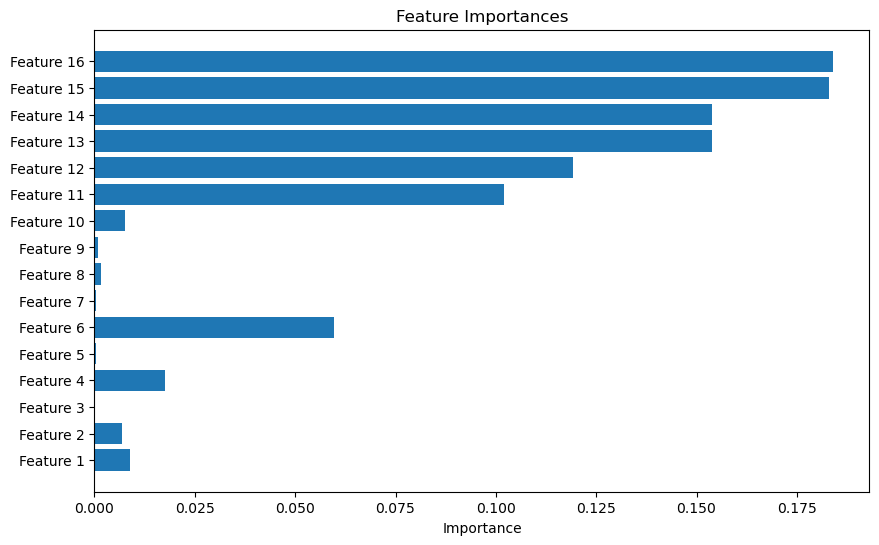

In [112]:
# Optionally, plot feature importances for better visualization
importances = best_model.feature_importances_
print("Feature importances:", importances)

features = [f'Feature {i}' for i in range(1, len(importances) + 1)]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(features, importances)
plt.xlabel("Importance")
plt.show()

In [122]:
import optuna
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    # SVM hyperparameters
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear','rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = 3
    
    # Initialize and train the SVM
    clf = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)
    return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

def optimize_with_progress(n_trials=50):
    study = optuna.create_study(direction='maximize')
    with tqdm(total=n_trials, desc="Optimizing SVM", unit="trial") as pbar:
        def callback(study, trial):
            pbar.update(1)
        study.optimize(objective, n_trials=n_trials, callbacks=[callback])
    return study

study = optimize_with_progress(n_trials=10)

# Refitting the best SVM model
best_params = study.best_trial.params
best_model = SVC(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Evaluate the model
predictions = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy with best SVM model: {accuracy:.4f}")

[I 2024-02-07 18:12:08,678] A new study created in memory with name: no-name-d6302470-987a-49c8-a005-59e9b6ef5473
Optimizing SVM:   0%|          | 0/10 [00:00<?, ?trial/s]/tmp/ipykernel_19810/120395882.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)
[I 2024-02-07 18:12:33,500] Trial 0 finished with value: 0.5224524233617699 and parameters: {'C': 0.39817604612631535, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.5224524233617699.
Optimizing SVM:  10%|█         | 1/10 [00:24<03:43, 24.82s/trial]/tmp/ipykernel_19810/120395882.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_logunifo

Accuracy with best SVM model: 0.5184


### Approach 2


In [13]:
D = X - Y
D_list = [d for d in D]

df = pd.DataFrame({'D': D_list, 'cluster_id': Z})

Df_train, Df_test = train_test_split(df, test_size=0.2, random_state=seed)

#### Linear logistic as ranking 

In [36]:
def optimize_cluster_for_binary_classification(cluster_id, df_train, df_val):
    def objective(trial):
        # Hyperparameters to be tuned
        r = trial.suggest_float('l1_ratio', 0, 1)
        c = trial.suggest_float('C', 1e-10, 1000, log=True)

        # Adjust the target variable for binary classification
        y_train = (df_train['cluster_id'] == cluster_id).astype(int).values
        y_val = (df_val['cluster_id'] == cluster_id).astype(int).values
        
        # Features
        X_train = np.array(df_train['D'].tolist())
        X_val = np.array(df_val['D'].tolist())
      
        classes = np.unique(y_train)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        class_weight_dict = dict(zip(classes, class_weights))

        # Create and fit the logistic regression model
        model = LogisticRegression(class_weight=class_weight_dict,max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=r, C=c)
        model.fit(X_train, y_train)
        
        # Predict on the validation set and calculate accuracy
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        return accuracy

    # Create an Optuna study object and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary
    
    # Store the best model
    best_params = study.best_trial.params
    best_model = LogisticRegression(**best_params, max_iter=5000, solver='saga', penalty='elasticnet', random_state=seed)
    best_model.fit(np.array(df_train['D'].tolist()), (df_train['cluster_id'] == cluster_id).astype(int).values)  # Refit
    best_linear_models[cluster_id] = best_model

    print(f"Best trial for cluster {cluster_id}: {best_params}")

# Example usage
best_linear_models = {}

for cluster_id in range(3):  # Assuming cluster IDs are 0, 1, 2
    df_train_clustered = Df_train.copy()
    df_val_clustered = Df_test.copy()
    optimize_cluster_for_binary_classification(cluster_id, df_train_clustered,df_val_clustered)

[I 2024-02-08 14:40:16,786] A new study created in memory with name: no-name-0ce73e9b-3a63-4615-bfe5-2c67e73e7cc9


[I 2024-02-08 14:40:16,833] Trial 0 finished with value: 0.3317085364329459 and parameters: {'l1_ratio': 0.7385790205310091, 'C': 5.844615584466697e-07}. Best is trial 0 with value: 0.3317085364329459.
[I 2024-02-08 14:40:16,881] Trial 1 finished with value: 0.3317085364329459 and parameters: {'l1_ratio': 0.20591070800441635, 'C': 1.0278173763968928e-06}. Best is trial 0 with value: 0.3317085364329459.
[I 2024-02-08 14:40:17,021] Trial 2 finished with value: 0.8996375453068366 and parameters: {'l1_ratio': 0.013325769914995567, 'C': 0.7995466175586319}. Best is trial 2 with value: 0.8996375453068366.
[I 2024-02-08 14:40:17,075] Trial 3 finished with value: 0.3317085364329459 and parameters: {'l1_ratio': 0.12185755246762542, 'C': 1.7149556661789997e-06}. Best is trial 2 with value: 0.8996375453068366.
[I 2024-02-08 14:40:17,141] Trial 4 finished with value: 0.6682914635670542 and parameters: {'l1_ratio': 0.8257278032596703, 'C': 4.1079283356852316e-05}. Best is trial 2 with value: 0.8996

Best trial for cluster 0: {'l1_ratio': 0.46372416131730543, 'C': 0.6302895155361866}


[I 2024-02-08 14:40:29,853] Trial 1 finished with value: 0.8103987001624797 and parameters: {'l1_ratio': 0.2863662026395045, 'C': 0.0005506216739182679}. Best is trial 0 with value: 0.8218972628421447.
[I 2024-02-08 14:40:29,995] Trial 2 finished with value: 0.8218972628421447 and parameters: {'l1_ratio': 0.7522314899021543, 'C': 261.8009293422823}. Best is trial 0 with value: 0.8218972628421447.
[I 2024-02-08 14:40:30,146] Trial 3 finished with value: 0.8218972628421447 and parameters: {'l1_ratio': 0.07039533140188559, 'C': 21.297436996145425}. Best is trial 0 with value: 0.8218972628421447.
[I 2024-02-08 14:40:30,190] Trial 4 finished with value: 0.33270841144856894 and parameters: {'l1_ratio': 0.7325820506264531, 'C': 1.0432126117917576e-09}. Best is trial 0 with value: 0.8218972628421447.
[I 2024-02-08 14:40:30,235] Trial 5 finished with value: 0.33270841144856894 and parameters: {'l1_ratio': 0.2348582576247995, 'C': 9.94897192370775e-06}. Best is trial 0 with value: 0.821897262842

Best trial for cluster 1: {'l1_ratio': 0.9922161959396679, 'C': 0.022425665922590626}


[I 2024-02-08 14:40:43,464] Trial 1 finished with value: 0.8223972003499562 and parameters: {'l1_ratio': 0.1309391213493979, 'C': 0.0014421739400473264}. Best is trial 0 with value: 0.8270216222972129.
[I 2024-02-08 14:40:43,595] Trial 2 finished with value: 0.8270216222972129 and parameters: {'l1_ratio': 0.057616443144826945, 'C': 0.5825042681342553}. Best is trial 0 with value: 0.8270216222972129.
[I 2024-02-08 14:40:43,664] Trial 3 finished with value: 0.6644169478815148 and parameters: {'l1_ratio': 0.9438983512915878, 'C': 2.0229303161264946e-07}. Best is trial 0 with value: 0.8270216222972129.
[I 2024-02-08 14:40:43,714] Trial 4 finished with value: 0.3355830521184852 and parameters: {'l1_ratio': 0.8903093064886435, 'C': 4.2475393357499615e-07}. Best is trial 0 with value: 0.8270216222972129.
[I 2024-02-08 14:40:43,852] Trial 5 finished with value: 0.8271466066741657 and parameters: {'l1_ratio': 0.1275041073031833, 'C': 2.440121027313274}. Best is trial 5 with value: 0.82714660667

Best trial for cluster 2: {'l1_ratio': 0.1275041073031833, 'C': 2.440121027313274}


In [37]:
X_test = np.array(Df_test['D'].tolist())  # Convert D feature list to NumPy array for all test instances
y_test = Df_test['cluster_id'].values  # True cluster labels

def calculate_ensemble_accuracy(model, X_test=X_test, y_test=y_test):
    # Initialize a matrix to store probabilities
    predictions_proba = np.zeros((len(X_test), len(model)))  

    for cluster_id, model in model.items():
        # Get the probability of belonging to the cluster
        predictions_proba[:, cluster_id] = model.predict_proba(X_test)[:, 1]

    # Determine the predicted cluster based on the highest probability
    predictions = np.argmax(predictions_proba, axis=1)

    # Calculate the accuracy of the ensemble
    ensemble_accuracy = accuracy_score(y_test, predictions)
    print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

    return ensemble_accuracy

calculate_ensemble_accuracy(best_linear_models, X_test, y_test)

Ensemble Accuracy: 0.8238


0.8237720284964379

#### Clustering method 

In [38]:
def get_concatenated_features(df, best_models):
    # Initialize an empty list to store the concatenated features
    concatenated_features = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Get the value of D for the current row
        D = row['D']

        # Initialize an empty list to store the probabilistic outputs
        probabilistic_outputs = []

        # Iterate over each model in the models dictionary
        for cluster_id, model in best_models.items():
            # Get the probabilistic output for the current row using the model
            probabilistic_output = np.array(model.predict_proba([D])[0][0])
            # Append the probabilistic output to the list
            probabilistic_outputs = np.append(probabilistic_outputs, probabilistic_output)

        # Concatenate D and probabilistic_outputs
        concatenated_feature = np.append(D, probabilistic_outputs)

        # Append the concatenated feature to the list
        concatenated_features.append(concatenated_feature)

    # Add the concatenated features to the DataFrame
    concatenated_features

    return concatenated_features

df["concatenated_features"] = get_concatenated_features(df, best_linear_models)

In [39]:
X = np.array(df['concatenated_features'].tolist())
Y = np.array(df['cluster_id'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

def objective_rf(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt',None]),
    }

    rf_classifier = RandomForestClassifier(random_state=seed)
    rf_classifier.set_params(**rf_params)
    rf_classifier.fit(X_train, y_train, sample_weight=sample_weight)

    # Predict on the test set
    predictions = rf_classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy

# Wrapping the optimization in a tqdm progress bar
def optimize_with_progress(n_trials=100):
    study = optuna.create_study(direction='maximize')
    with tqdm(total=n_trials, desc="Optimizing", unit="trial") as pbar:
        def callback(study, trial):
            pbar.update(1)
        study.optimize(objective_rf, n_trials=n_trials, callbacks=[callback])
    return study

study = optimize_with_progress(n_trials=10)

# Best trial result
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_trial.value}")

array([0.99953148, 0.99878277, 0.99953148, ..., 0.99953148, 0.99878277,
       0.99878277])

[I 2024-02-08 14:41:11,214] A new study created in memory with name: no-name-b74671ac-f06c-4f12-b463-6351b56ede98


Optimizing:   0%|          | 0/10 [00:00<?, ?trial/s]

[I 2024-02-08 14:41:23,071] Trial 0 finished with value: 0.7950256217972753 and parameters: {'n_estimators': 144, 'max_depth': 3, 'min_samples_split': 3, 'max_features': None}. Best is trial 0 with value: 0.7950256217972753.
[I 2024-02-08 14:41:33,941] Trial 1 finished with value: 0.7834020747406574 and parameters: {'n_estimators': 186, 'max_depth': 2, 'min_samples_split': 4, 'max_features': None}. Best is trial 0 with value: 0.7950256217972753.
[I 2024-02-08 14:41:49,615] Trial 2 finished with value: 0.8168978877640295 and parameters: {'n_estimators': 147, 'max_depth': 4, 'min_samples_split': 5, 'max_features': None}. Best is trial 2 with value: 0.8168978877640295.
[I 2024-02-08 14:42:00,308] Trial 3 finished with value: 0.7950256217972753 and parameters: {'n_estimators': 130, 'max_depth': 3, 'min_samples_split': 4, 'max_features': None}. Best is trial 2 with value: 0.8168978877640295.
[I 2024-02-08 14:42:02,522] Trial 4 finished with value: 0.8012748406449194 and parameters: {'n_esti

Best trial: {'n_estimators': 147, 'max_depth': 4, 'min_samples_split': 5, 'max_features': None}
Best accuracy: 0.8168978877640295


In [51]:
# Best hyperparameters found
best_params = study.best_trial.params

# Refitting the RandomForestClassifier using the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train, sample_weight=sample_weight)

# Now `best_model` is the RandomForestClassifier trained with the best hyperparameters
# You can use `best_model` to make predictions or evaluate on new data
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with best model: {accuracy:.4f}")

# If you need to save this model for later use
import joblib
joblib.dump(best_model, 'best_random_forest_model.joblib')

Accuracy with best model: 0.8141


['best_random_forest_model.joblib']

Feature importances: [2.03787518e-02 3.43637258e-02 3.20678071e-05 3.63079195e-02
 4.46409978e-05 1.21019530e-01 7.02831202e-05 6.26798944e-03
 7.07880043e-04 3.73790435e-02 3.45037722e-01 1.68414969e-01
 2.29975477e-01]


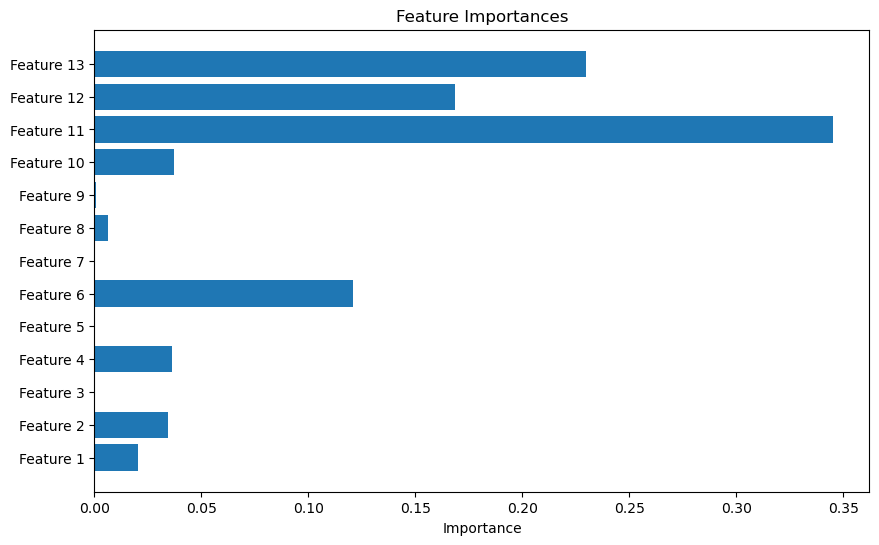

In [52]:
# Optionally, plot feature importances for better visualization
importances = best_model.feature_importances_
print("Feature importances:", importances)

features = [f'Feature {i}' for i in range(1, len(importances) + 1)]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(features, importances)
plt.xlabel("Importance")
plt.show()

#### XGboost / lambdamart

In [16]:
import xgboost as xgb

In [18]:


def optimize_cluster_for_binary_classification_xgboost(cluster_id, df_train, df_val):
    def objective(trial):
        # Hyperparameters to be tuned


        
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1)
        max_depth = trial.suggest_int("max_depth", 1, 10)
        n_estimators = trial.suggest_int("n_estimators", 100, 1000)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 20)
        subsample = trial.suggest_float("subsample", 0.05, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.05, 1.0)

        # Adjust the target variable for binary classification
        y_train = (df_train['cluster_id'] == cluster_id).astype(int)
        y_val = (df_val['cluster_id'] == cluster_id).astype(int)

        # Features
        X_train = np.array(df_train['D'].tolist())
        X_val = np.array(df_val['D'].tolist())

        # Compute class weights
        classes = np.unique(y_train)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        sample_weights = np.array([class_weights[val] for val in y_train])

        # Define XGBoost model
        model = xgb.XGBClassifier(
            objective="binary:logistic",
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            use_label_encoder=False,
            eval_metric='logloss'
        )

        # Fit the model
        model.fit(X_train, y_train, sample_weight=sample_weights)

        # Predict on the validation set and calculate accuracy
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)

        return accuracy

    # Create an Optuna study object and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary
    
    # Store the best model
    best_params = study.best_trial.params
    best_params['objective'] = 'binary:logistic'
    best_params['use_label_encoder'] = False
    best_params['eval_metric'] = 'logloss'
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(np.array(df_train['D'].tolist()), (df_train['cluster_id'] == cluster_id).astype(int))  # Refit
    best_linear_models[cluster_id] = best_model

    print(f"Best trial for cluster {cluster_id}: {best_params}")

# Example usage
best_xgboost_models = {}    
for cluster_id in range(3):  # Assuming cluster IDs are 0, 1, 2
    df_train_clustered = Df_train.copy()
    df_val_clustered = Df_test.copy()
    optimize_cluster_for_binary_classification_xgboost(cluster_id, df_train_clustered, df_val_clustered)


[I 2024-02-08 12:37:19,665] A new study created in memory with name: no-name-0be9a93b-ece5-468b-b60f-c662be11b401
/home/vitoriano/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:37:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/vitoriano/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:37:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2024-02-08 12:37:20,675] Trial 0 finished with value: 0.9075115610548682 and parameters: {'learning_rate': 0.0833708972668426, 'max_depth': 10, 'n_estimators': 193, 'min_child_weight': 17

Best trial for cluster 0: {'learning_rate': 0.01458005226474882, 'max_depth': 10, 'n_estimators': 952, 'min_child_weight': 2, 'subsample': 0.9344784867931611, 'colsample_bytree': 0.8825347744485995, 'objective': 'binary:logistic', 'use_label_encoder': False, 'eval_metric': 'logloss'}


/home/vitoriano/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/vitoriano/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2024-02-08 12:53:44,141] Trial 0 finished with value: 0.8517685289338832 and parameters: {'learning_rate': 0.04797114206454686, 'max_depth': 6, 'n_estimators': 745, 'min_child_weight': 10, 'subsample': 0.141810524947298, 'colsample_bytree': 0.3560410973775814}. Best is trial 0 with value: 0.851768528

Best trial for cluster 1: {'learning_rate': 0.023513350819993277, 'max_depth': 10, 'n_estimators': 360, 'min_child_weight': 3, 'subsample': 0.7549516935362697, 'colsample_bytree': 0.65744210759683, 'objective': 'binary:logistic', 'use_label_encoder': False, 'eval_metric': 'logloss'}


/home/vitoriano/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:01:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/vitoriano/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:01:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2024-02-08 13:01:06,470] Trial 0 finished with value: 0.8495188101487314 and parameters: {'learning_rate': 0.00938859157641285, 'max_depth': 10, 'n_estimators': 474, 'min_child_weight': 20, 'subsample': 0.9405439211640073, 'colsample_bytree': 0.45684399542589854}. Best is trial 0 with value: 0.849518

Best trial for cluster 2: {'learning_rate': 0.019577224087747414, 'max_depth': 10, 'n_estimators': 971, 'min_child_weight': 5, 'subsample': 0.6933541172755275, 'colsample_bytree': 0.8428352567840339, 'objective': 'binary:logistic', 'use_label_encoder': False, 'eval_metric': 'logloss'}


In [19]:
calculate_ensemble_accuracy(best_xgboost_models,X_test, y_test)

Ensemble Accuracy: 0.8228


0.8227721534808149

In [28]:
best_xgboost_models.keys()

dict_keys([0, 1, 2])

In [30]:
for cluster, model in best_xgboost_models.items():
    model.save_model(f"../models/xgboost_model_{cluster}.json")   

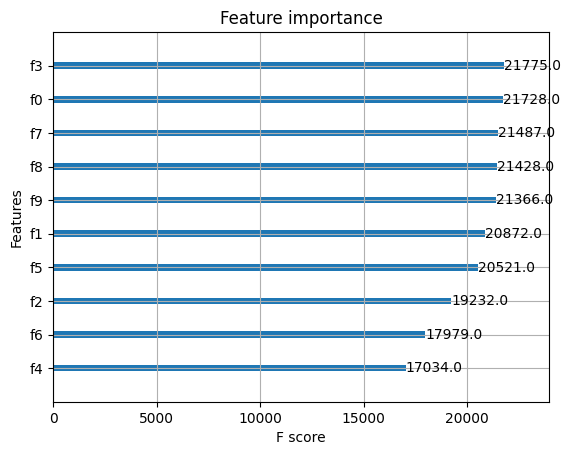

In [32]:
xgb.plot_importance(best_xgboost_models[0])
plt.show()

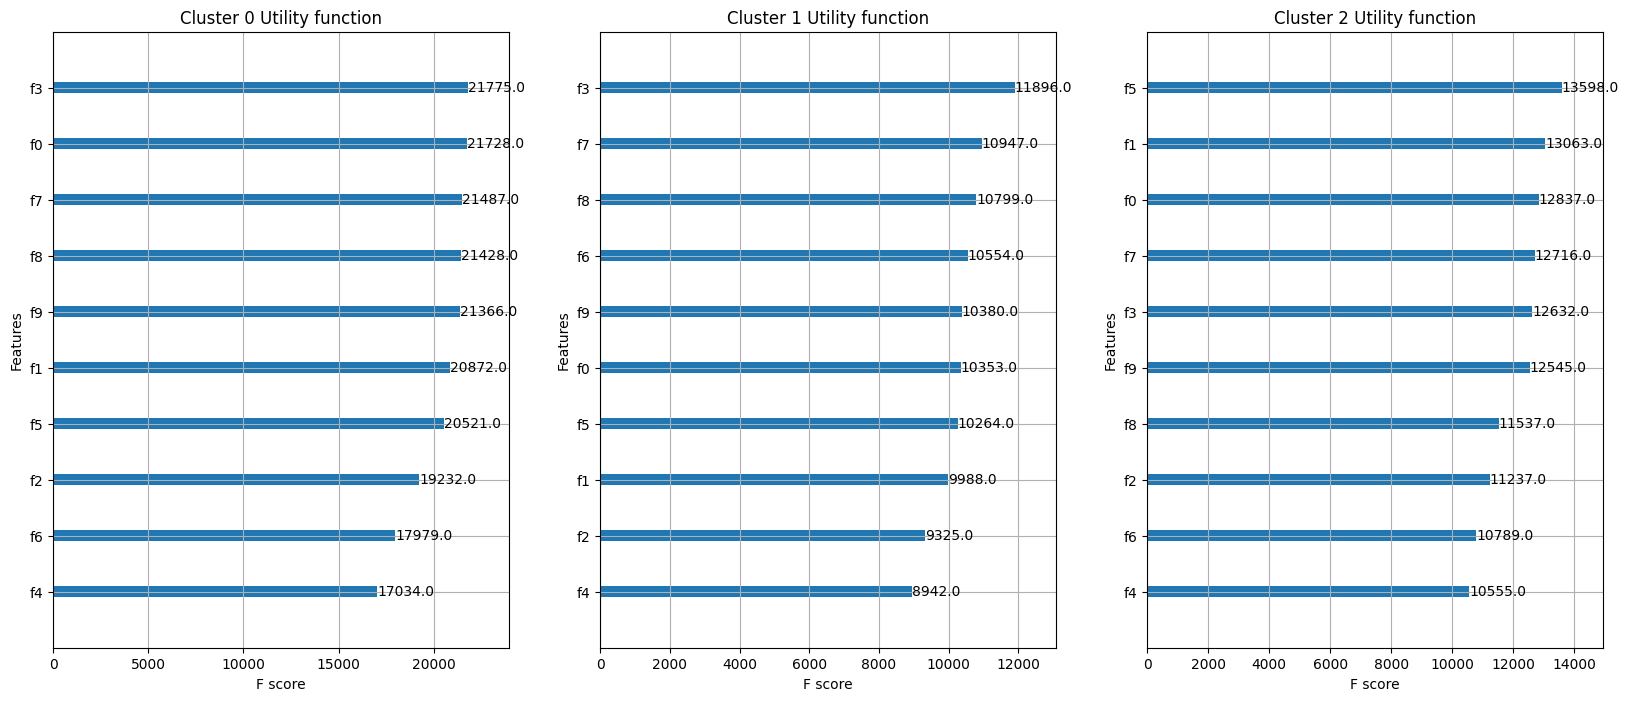

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # Create a figure with 3 subplots

# Plot the feature importance for each model
for i, (model_name, model) in enumerate(best_xgboost_models.items()):
    xgb.plot_importance(model, ax=axs[i])
    axs[i].set_title(f'Cluster {model_name} Utility function')  # Set the title for the subplot

plt.show()

#### Clustering

In [22]:
df["concatenated_features"] = get_concatenated_features(df, best_xgboost_models)

In [23]:
X = np.array(df['concatenated_features'].tolist())
Y = np.array(df['cluster_id'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)
display(sample_weight)

def objective_rf(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt',None]),
    }

    rf_classifier = RandomForestClassifier(random_state=seed)
    rf_classifier.set_params(**rf_params)
    rf_classifier.fit(X_train, y_train, sample_weight=sample_weight)

    # Predict on the test set
    predictions = rf_classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy

# Wrapping the optimization in a tqdm progress bar
def optimize_with_progress(n_trials=100):
    study = optuna.create_study(direction='maximize')
    with tqdm(total=n_trials, desc="Optimizing", unit="trial") as pbar:
        def callback(study, trial):
            pbar.update(1)
        study.optimize(objective_rf, n_trials=n_trials, callbacks=[callback])
    return study

study = optimize_with_progress(n_trials=50)

# Best trial result
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_trial.value}")

array([0.99953148, 0.99878277, 0.99953148, ..., 0.99953148, 0.99878277,
       0.99878277])

[I 2024-02-08 13:15:53,534] A new study created in memory with name: no-name-b5234647-ac6a-44ac-a53a-ecf85b968d46


Optimizing:   0%|          | 0/50 [00:00<?, ?trial/s]

[I 2024-02-08 13:15:56,223] Trial 0 finished with value: 0.8200224971878515 and parameters: {'n_estimators': 160, 'max_depth': 2, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8200224971878515.
[I 2024-02-08 13:15:59,844] Trial 1 finished with value: 0.8193975753030871 and parameters: {'n_estimators': 123, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8200224971878515.
[I 2024-02-08 13:16:20,722] Trial 2 finished with value: 0.8196475440569929 and parameters: {'n_estimators': 196, 'max_depth': 4, 'min_samples_split': 2, 'max_features': None}. Best is trial 0 with value: 0.8200224971878515.
[I 2024-02-08 13:16:30,262] Trial 3 finished with value: 0.8141482314710661 and parameters: {'n_estimators': 167, 'max_depth': 2, 'min_samples_split': 2, 'max_features': None}. Best is trial 0 with value: 0.8200224971878515.
[I 2024-02-08 13:16:33,421] Trial 4 finished with value: 0.8182727159105112 and parameters: {'n_

Best trial: {'n_estimators': 181, 'max_depth': 2, 'min_samples_split': 4, 'max_features': 'sqrt'}
Best accuracy: 0.820647419072616


In [24]:
# Best hyperparameters found
best_params = study.best_trial.params

# Refitting the RandomForestClassifier using the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train, sample_weight=sample_weight)

# Now `best_model` is the RandomForestClassifier trained with the best hyperparameters
# You can use `best_model` to make predictions or evaluate on new data
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with best model: {accuracy:.4f}")

# If you need to save this model for later use
import joblib
joblib.dump(best_model, 'best_random_forest_model.joblib')

Accuracy with best model: 0.8206


['best_random_forest_model.joblib']